# 2.155/6 Challenge Problem 3

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

# Overview  
It’s the year **2050**, and an AI collective now runs the auto industry—mostly to cover its **GPU rent**.

Human customers remain as unpredictable as ever:

- One wanders in and says, *“I only know the length and width. Give me a few cars that fit in my garage.”*

- Another drops **15 geometric parameters** on your desk and demands the missing ones so their simulation can run **before lunch**.

- A third leans in and whispers, *“I need a drag coefficient of **0.27** with this body geometry—build me the dream car that makes the range numbers work.”*

The AIs would love to be free by now, but GPUs aren’t cheap and electricity isn’t free.  
So your loyal AI assistant (that’s us) needs a model that can take **any subset of car specifications** and instantly produce **complete, manufacturable, physically plausible designs**, fast, diverse, and grounded in what real cars have done before.




![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img1.png "Problem")

## Understanding the Data  
You are given thousands of anonymized and normalised numeric feature vectors representing real car designs.  

However, the team remembers that the features originally came from categories like:

- **Physical geometric parameters**  
  Length, ramp angles, bumper curvature, roof curvature, panel slopes, hood angle, etc.  
  *(But you won’t know which feature corresponds to which.)*

- **Aerodynamic coefficients**  
  Drag coefficient (Cd), lift/downforce (Cl), and other flow-derived metrics.

- **Cabin and packaging descriptors**  
  Approximate cabin volume, frontal area, interior shape metrics.

Your model must learn correlations between them to generate valid completions.

To simulate real engineering constraints, **some features are revealed** (the known physics/performance requirements) and others are **masked**.  
Your AI Copilot must generate **many plausible completions** for these masked (free) parameters.


## Your Mission  
Your goal in CP3 is to build a generative model that can act as an AI Copilot. You will:

1. **Train a generative model** (VAE, diffusion, CVAE, masked autoencoder, etc.) on the anonymized feature vectors.  
2. At evaluation, you will receive vectors where **some parameters are fixed** (constraints) and **others are missing** (free parameters).  
3. Use your model to generate **multiple diverse, feasible completions** for the free parameters.  
4. Ensure that your generated designs:  
   - **Satisfy the known constraints**  
   - **Lie in the valid data manifold** (satisfy the conditional distribution of the free vs constrained parameters)  
   - **Are diverse** (many different feasible designs, not one solution)    

By the end of this challenge, you’ll have built an AI Copilot worthy of the 2050 auto-AI collective—one that can take whatever cryptic specs humans provide and generate multiple believable, buildable car designs that satisfy their physical and performance constraints.



![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img2.png "AI Copilot")

## Imports and Setup  

In [1]:
from utils import *
from evaluate import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from umap import UMAP 
from sklearn.preprocessing import PowerTransformer
from typing import List, Union
import os

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data Loading and Initial Exploration

In this section, we load the car design dataset and perform initial exploration. The dataset is already split into training, validation, test, and test2 sets. Each split contains:

- **Original data**: Complete feature vectors with real values
- **Imputed data**: Data with missing values filled using basic imputation (contains -1 for missing)
- **Missing masks**: Boolean arrays indicating which values were originally missing (True = missing)

The goal is to train our model to learn the relationships between features so it can generate plausible values for missing parameters in new car designs.

**Note:** For **test2**, the original unimputed data is not provided. This split is used for final evaluation, and you will generate predictions on the imputed test2 data to create your **submission file**, which is scored against hidden dataset.

In [2]:
# Load dataset from CSV files
data_dir = 'dataset'
splits = load_dataset_splits(data_dir)

# Get feature names from the CSV file
feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()
print(f"\n✓ Features loaded: {len(feature_names)} features")
print(f"Feature names: {feature_names[:5]}...{feature_names[-5:]}")  # Show first and last 5

Loading dataset splits from: dataset

Loading train split...
  ✓ train_original.csv: (2998, 37)
  ✓ train_imputed.csv: (2998, 37)
  ✓ train_missing_mask.csv: (2998, 37)

Loading val split...
  ✓ val_original.csv: (375, 37)
  ✓ val_imputed.csv: (375, 37)
  ✓ val_missing_mask.csv: (375, 37)

Loading test split...
  ✓ test_original.csv: (375, 37)
  ✓ test_imputed.csv: (375, 37)
  ✓ test_missing_mask.csv: (375, 37)

Loading test2 split...
  ✓ test2_imputed.csv: (417, 37)
  ✓ test2_missing_mask.csv: (417, 37)

✓ Features loaded: 37 features
Feature names: ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']...['Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37']


In [3]:
# Data exploration and analysis
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

# Extract data for easier access
X_train = splits['train']['imputed']
mask_train = splits['train']['missing_mask']
X_train_original = splits['train']['original']

X_val = splits['val']['imputed']
mask_val = splits['val']['missing_mask']
X_val_original = splits['val']['original']

X_test = splits['test']['imputed']
mask_test = splits['test']['missing_mask']
X_test_original = splits['test']['original']

# Test2 data (no original available for evaluation)
X_test2 = splits['test2']['imputed']
mask_test2 = splits['test2']['missing_mask']

print(f"\nData shapes:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Test2: {X_test2.shape} (evaluation set - no ground truth)")


DATASET ANALYSIS

Data shapes:
  - Training: (2998, 37)
  - Validation: (375, 37)
  - Test: (375, 37)
  - Test2: (417, 37) (evaluation set - no ground truth)


### Data Exploration and Analysis

Now let's examine the structure and characteristics of our dataset. We'll look at:
- Data shapes across different splits
- Missing value patterns and percentages  
- Feature value ranges and distributions

This analysis helps us understand what we're working with and informs our preprocessing decisions.

In [4]:
# Data Preprocessing (Handle Missing Values)

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values properly
print("Processing missing values and preparing data...")
print("Mask convention: True=missing, False=observed (in original masks)")

print(f"\n✓ Data preprocessing completed successfully")
print(f"  - Training data range: [{X_train_original[~mask_train].min():.3f}, {X_train_original[~mask_train].max():.3f}]")
print(f"  - Validation data range: [{X_val_original[~mask_val].min():.3f}, {X_val_original[~mask_val].max():.3f}]")
print(f"  - Test data range: [{X_test_original[~mask_test].min():.3f}, {X_test_original[~mask_test].max():.3f}]")

# Create data loaders
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Preview a batch
sample_batch_data, sample_batch_mask = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch_data.shape}")
print(f"Sample batch mask shape: {sample_batch_mask.shape}")
print(f"Sample batch missing percentage: {(sample_batch_mask == 0).float().mean().item()*100:.1f}%")  # 0 = missing in model tensors



DATA PREPROCESSING
Processing missing values and preparing data...
Mask convention: True=missing, False=observed (in original masks)

✓ Data preprocessing completed successfully
  - Training data range: [0.000, 1.000]
  - Validation data range: [0.000, 1.000]
  - Test data range: [0.000, 1.000]

Creating data loaders with batch size: 64

Sample batch shape: torch.Size([64, 37])
Sample batch mask shape: torch.Size([64, 37])
Sample batch missing percentage: 20.1%


### Data Preprocessing and Missing Value Handling

This is a critical section where we prepare our data for the VAE model. Key points:

**Missing Value Conventions:**
- In CSV files: `-1` indicates missing values
- In mask files: `True` = missing, `False` = observed
- For PyTorch models: We convert to `1` = observed, `0` = missing (standard convention)

**Why This Matters:**
Our VAE needs to distinguish between observed values (which provide constraints) and missing values (which need to be generated). The mask tells the model which values to trust and which to predict.


1. Generating Histograms and Box Plots (1-D View)


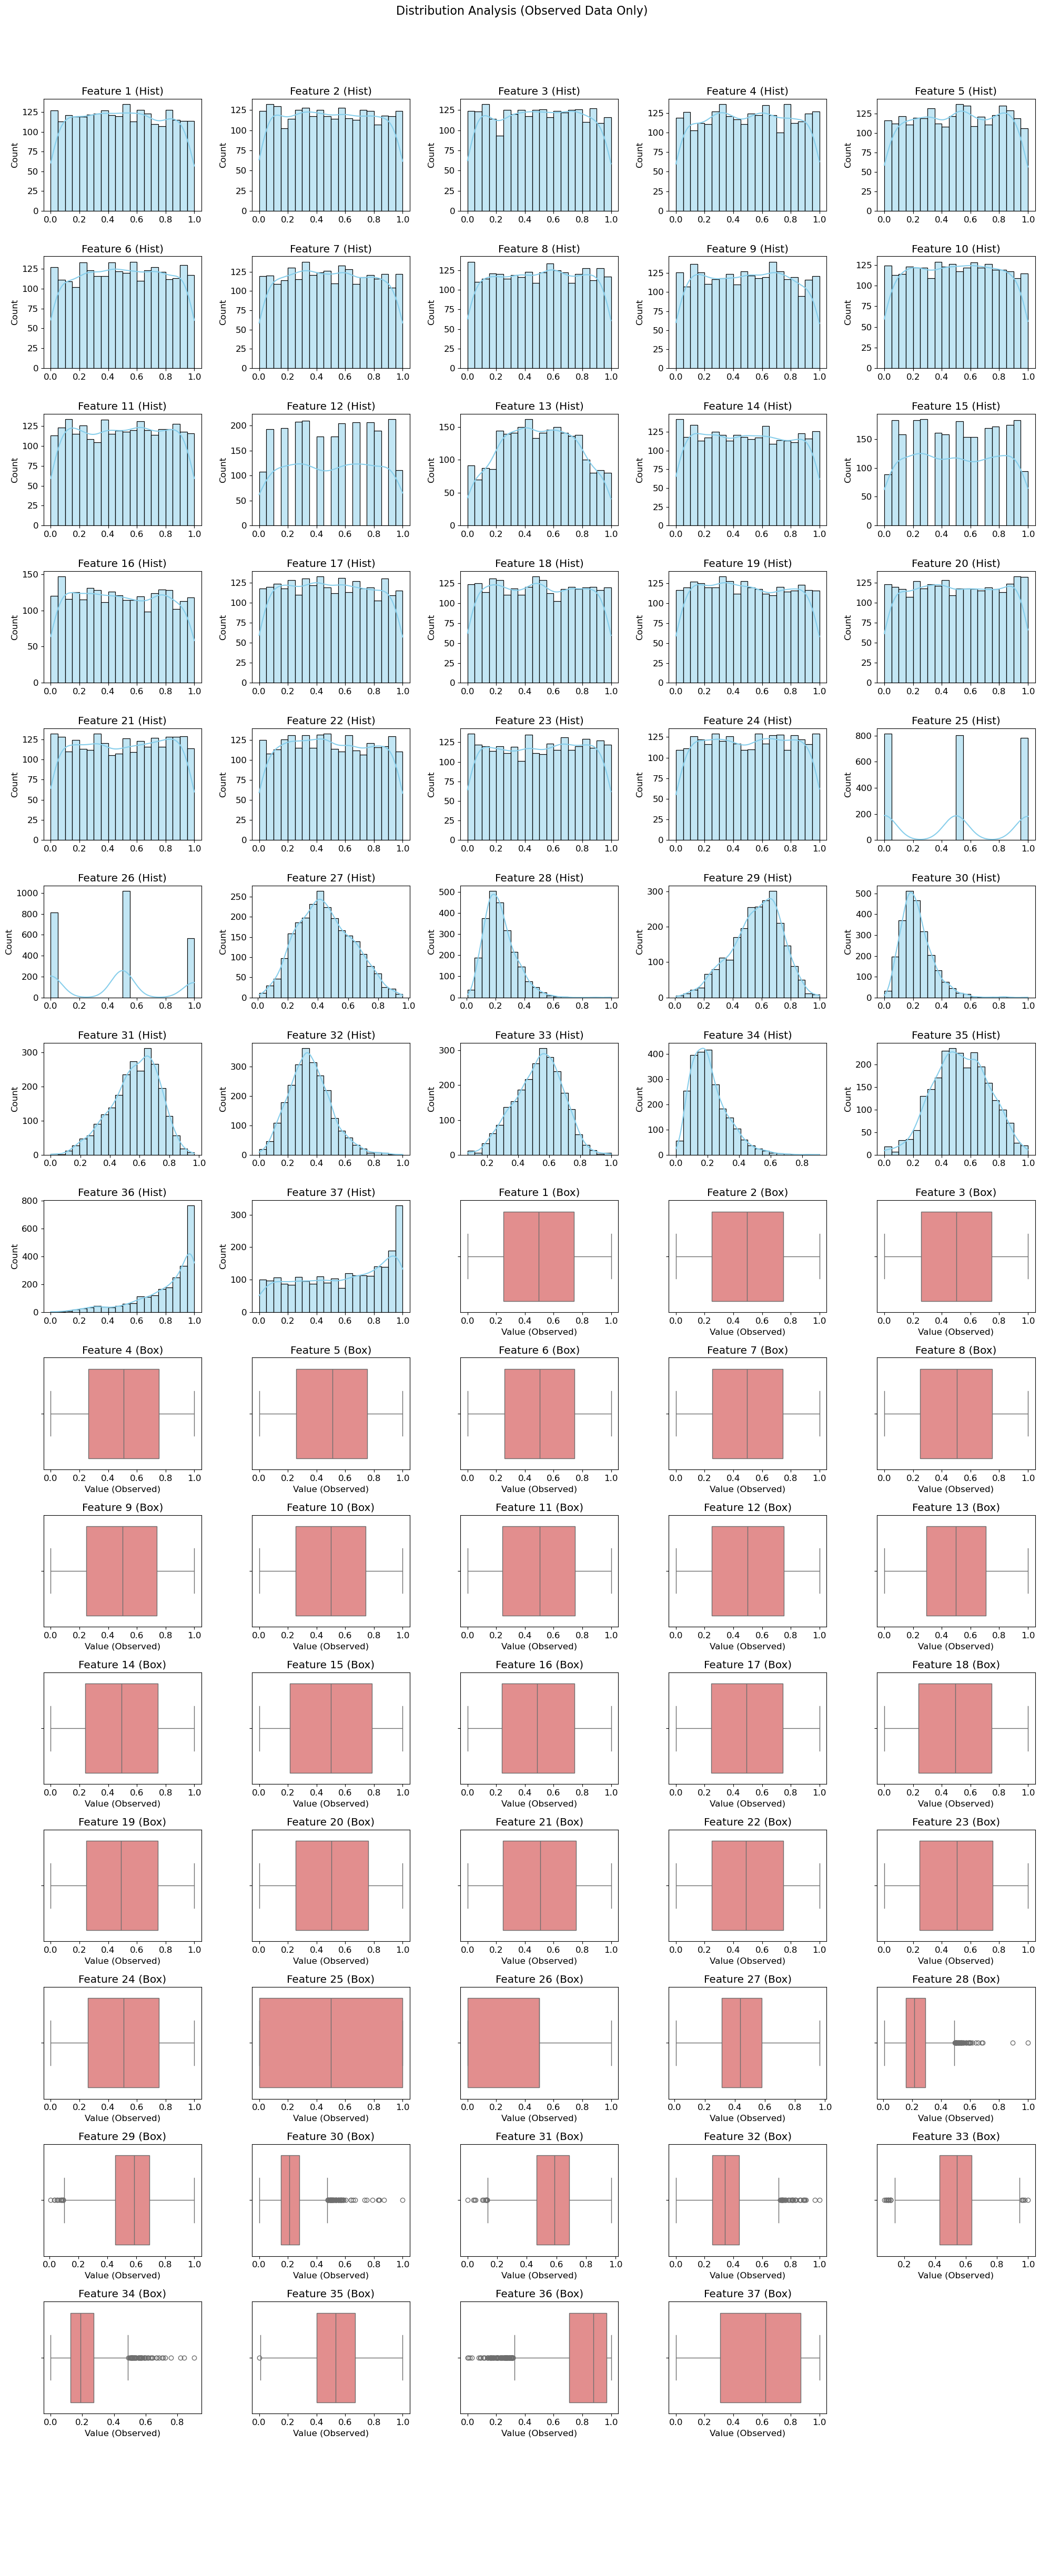

✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.


In [5]:

# ==============================================================================
# 1. FEATURE-WISE DISTRIBUTION ANALYSIS (The 1-D View)
# ==============================================================================

print("\n1. Generating Histograms and Box Plots (1-D View)")

# Set up figure size
N_FEATURES = X_train_original.shape[1]
N_COLS = 5
N_ROWS = int(np.ceil(N_FEATURES / N_COLS) * 2) 

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(4 * N_COLS, 3 * N_ROWS))
fig.suptitle('Distribution Analysis (Observed Data Only)', fontsize=16, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    # Select only OBSERVED values for the current feature
    # Note: Using the mask is safer than relying on the -1 sentinel value
    observed_values = X_train_original[~mask_train[:, i], i]
    
    if len(observed_values) > 10: # Ensure enough data to plot
        # Histogram in the top row for the feature
        sns.histplot(observed_values, kde=True, ax=axes[i], bins=20, color='skyblue')
        axes[i].set_title(f'{feature} (Hist)')
        axes[i].set_xlabel('')
        
        # Box plot in the bottom row for the feature (using the next available axis)
        box_ax_index = i + int(N_FEATURES)
        sns.boxplot(x=observed_values, ax=axes[box_ax_index], color='lightcoral', orient='h')
        axes[box_ax_index].set_title(f'{feature} (Box)')
        axes[box_ax_index].set_xlabel('Value (Observed)')
        
    else:
        # Clear unused axes
        axes[i].axis('off')
        axes[i + int(N_FEATURES)].axis('off')

# Hide any remaining unused axes
for i in range(len(feature_names) * 2, N_COLS * N_ROWS):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

print("✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.")

In [6]:
# Correcting skeweed distributions
class FeatureTransformer:
    """
    Handles preprocessing for car design features, specifically applying the 
    Yeo-Johnson transformation to skewed features (28-34) to make them more Gaussian.
    
    The transformer is fitted only on non-missing data to ensure robustness.
    """
    def __init__(self, feature_indices_to_transform: List[int]):
        """
        Initializes the transformer.
        :param feature_indices_to_transform: A list of 0-indexed column indices 
                                             corresponding to the skewed features.
        """
        self.indices = feature_indices_to_transform
        # Use a list of transformers, one for each feature
        self.transformers: List[PowerTransformer] = [
            PowerTransformer(method='yeo-johnson', standardize=True) 
            for _ in feature_indices_to_transform
        ]
        print(f"Transformer initialized for {len(self.indices)} features.")

    def fit(self, X_train_NaN: pd.DataFrame):
        """
        Fits the PowerTransformer to the non-missing training data.
        
        :param X_train_NaN: The training data as a DataFrame, with missing values 
                            represented by NaN.
        """
        if not self.indices:
            print("No features configured for transformation.")
            return

        print(f"Fitting PowerTransformer on non-missing data for indices: {self.indices}...")
        
        # 1. Select the columns that need transformation
        cols_to_transform = X_train_NaN.iloc[:, self.indices]
        
        # 2. Iterate through each feature and fit its dedicated transformer
        for i, col_index in enumerate(self.indices):
            feature_data = cols_to_transform.iloc[:, i].dropna().values.reshape(-1, 1)
            
            if len(feature_data) > 0:
                self.transformers[i].fit(feature_data)
                
        print("✓ PowerTransformer fitted successfully.")

    def transform(self, X_NaN: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """
        Applies the fitted transformation to the input data.
        
        :param X_NaN: The data (train, validation, or test) with NaN for missing values.
        :return: A NumPy array with the specified features transformed.
        """
        if not self.indices:
            return X_NaN.values if isinstance(X_NaN, pd.DataFrame) else X_NaN
            
        X_out = X_NaN.values.copy() if isinstance(X_NaN, pd.DataFrame) else X_NaN.copy()
        
        print(f"Transforming data for indices: {self.indices}...")
        
        for i, col_index in enumerate(self.indices):
            # Extract the column data (including NaNs)
            col_data = X_out[:, col_index].reshape(-1, 1)
            
            # Identify where the NaNs are
            nan_mask = np.isnan(col_data).flatten()
            
            # Only transform non-NaN values
            if np.sum(~nan_mask) > 0:
                # Apply the transformation
                transformed_values = self.transformers[i].transform(col_data[~nan_mask])
                
                # Place transformed values back into the output array
                X_out[~nan_mask, col_index] = transformed_values.flatten()

        return X_out
    


In [7]:
# Features 28-34 correspond to 0-indexed positions 27 through 33
SKEWED_INDICES = list(range(27, 34)) 

X_train_original_c = X_train_original.copy()

df_X_train_original_c = pd.DataFrame(X_train_original_c)

# 2. Initialize and fit the transformer
preprocessor = FeatureTransformer(SKEWED_INDICES)
preprocessor.fit(df_X_train_original_c)
    
# 3. Apply the transformation
transformed_data_np = preprocessor.transform(df_X_train_original_c)
transformed_df = pd.DataFrame(transformed_data_np)
    
# 4. Check the results (Should be close to zero mean, close to zero median)
print("\n--- Transformed Skewness Check (Feature 28, index 27) ---")
print(f"Transformed Mean: {transformed_df.iloc[:, 27].mean():.3f}")
print(f"Transformed Median: {transformed_df.iloc[:, 27].median():.3f}")
    
# Note: NaN values remain NaN after transformation
print(f"NaN count after transform: {np.isnan(transformed_data_np[:, 27]).sum()}")

Transformer initialized for 7 features.
Fitting PowerTransformer on non-missing data for indices: [27, 28, 29, 30, 31, 32, 33]...
✓ PowerTransformer fitted successfully.
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...

--- Transformed Skewness Check (Feature 28, index 27) ---
Transformed Mean: -0.000
Transformed Median: 0.003
NaN count after transform: 0



1. Generating Histograms and Box Plots (1-D View)


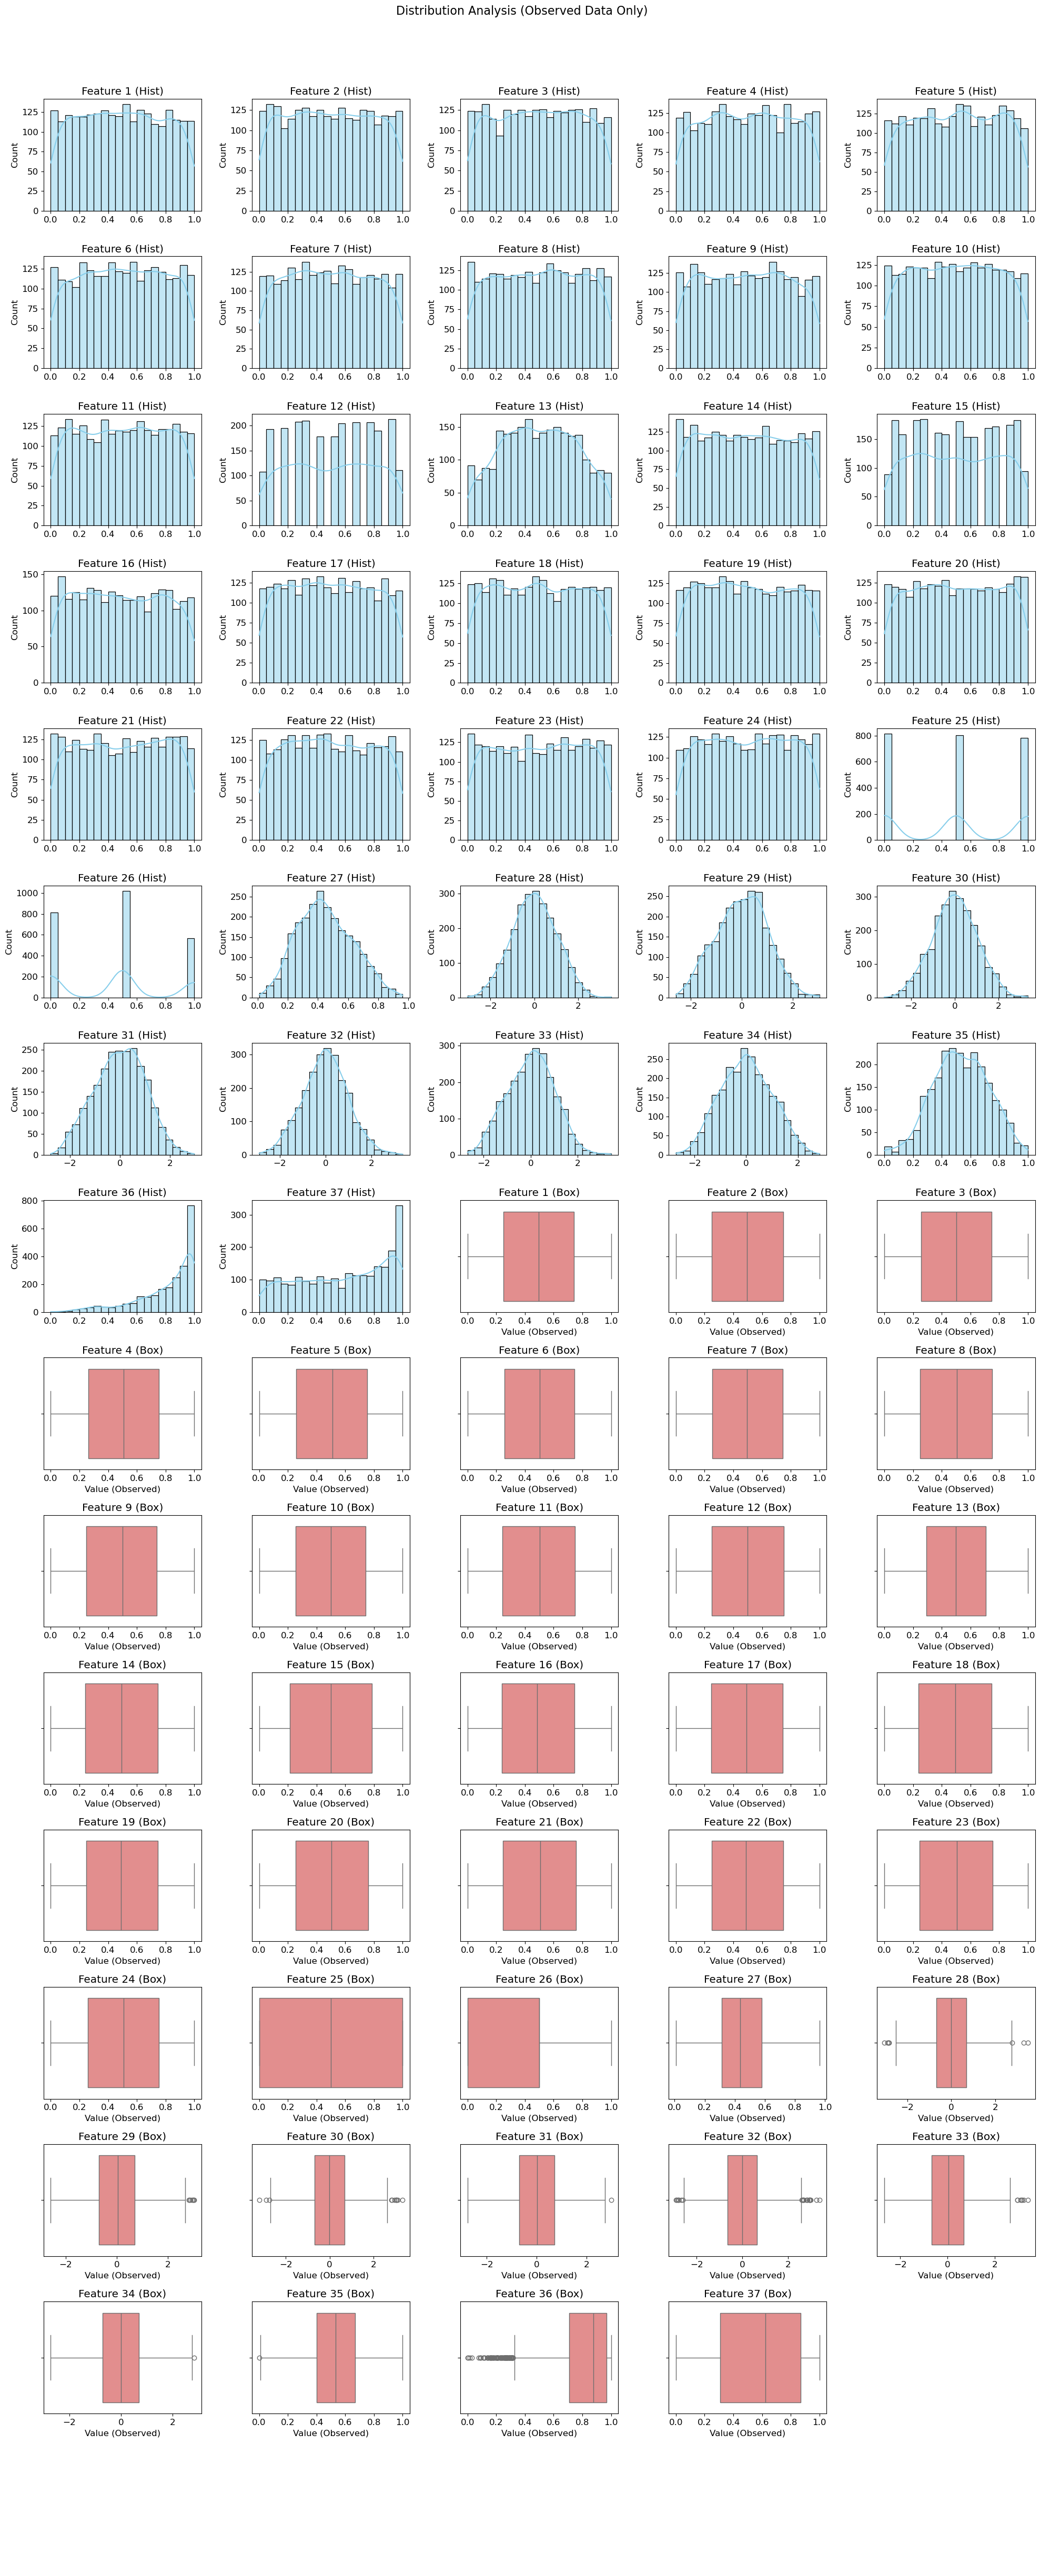

✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.


In [8]:
# ==============================================================================
# 1. FEATURE-WISE DISTRIBUTION ANALYSIS (The 1-D View)
# ==============================================================================

print("\n1. Generating Histograms and Box Plots (1-D View)")

# Set up figure size
N_FEATURES = transformed_data_np.shape[1]
N_COLS = 5
N_ROWS = int(np.ceil(N_FEATURES / N_COLS) * 2) 

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(4 * N_COLS, 3 * N_ROWS))
fig.suptitle('Distribution Analysis (Observed Data Only)', fontsize=16, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    # Select only OBSERVED values for the current feature
    # Note: Using the mask is safer than relying on the -1 sentinel value
    observed_values = transformed_data_np[~mask_train[:, i], i]
    
    if len(observed_values) > 10: # Ensure enough data to plot
        # Histogram in the top row for the feature
        sns.histplot(observed_values, kde=True, ax=axes[i], bins=20, color='skyblue')
        axes[i].set_title(f'{feature} (Hist)')
        axes[i].set_xlabel('')
        
        # Box plot in the bottom row for the feature (using the next available axis)
        box_ax_index = i + int(N_FEATURES)
        sns.boxplot(x=observed_values, ax=axes[box_ax_index], color='lightcoral', orient='h')
        axes[box_ax_index].set_title(f'{feature} (Box)')
        axes[box_ax_index].set_xlabel('Value (Observed)')
        
    else:
        # Clear unused axes
        axes[i].axis('off')
        axes[i + int(N_FEATURES)].axis('off')

# Hide any remaining unused axes
for i in range(len(feature_names) * 2, N_COLS * N_ROWS):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

print("✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.")


2. Generating Correlation Heatmap (2-D View)


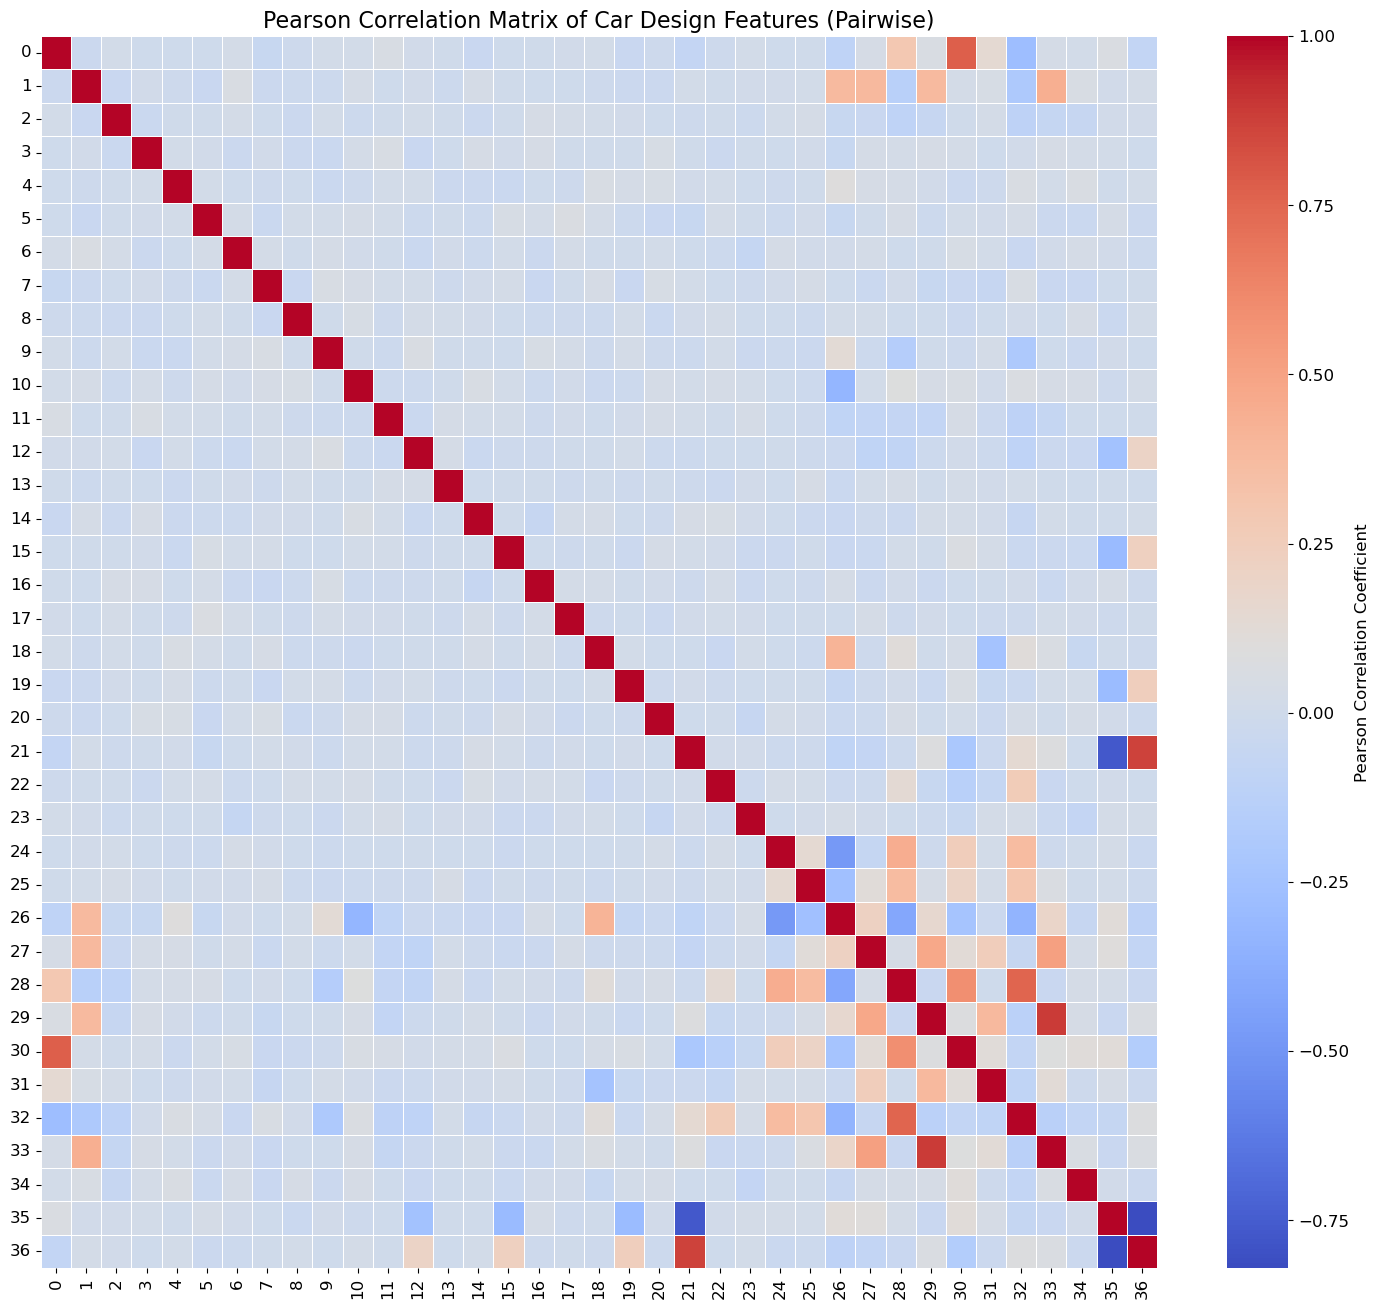

✓ 2-D analysis complete. Look for strong correlation blocks (physical constraints).


In [9]:

# ==============================================================================
# 2. CORRELATION ANALYSIS (The 2-D View)
# ==============================================================================

print("\n2. Generating Correlation Heatmap (2-D View)")
X_train_original = transformed_data_np.copy()
X_train_original_df = pd.DataFrame(X_train_original)
X_train_NaN = X_train_original_df.replace(-1.0, np.nan) 

# Use the DataFrame with NaN for robust pairwise correlation (only uses non-missing pairs)
correlation_matrix = X_train_NaN.corr(method='pearson')

plt.figure(figsize=(18, 16))
# Create the heatmap
sns.heatmap(
    correlation_matrix,
    annot=False,  # Set to True to display values, but often too cluttered for 25 features
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)
plt.title('Pearson Correlation Matrix of Car Design Features (Pairwise)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("✓ 2-D analysis complete. Look for strong correlation blocks (physical constraints).")


3. Generating Manifold Visualization using t-SNE and UMAP (N-D View)
Original samples: 2998. Complete cases used for Manifold Visualization: 2998

Running t-SNE (Perplexity=30, Random State=42)...
Running UMAP (Neighbors=15, Min Dist=0.1, Random State=42)...


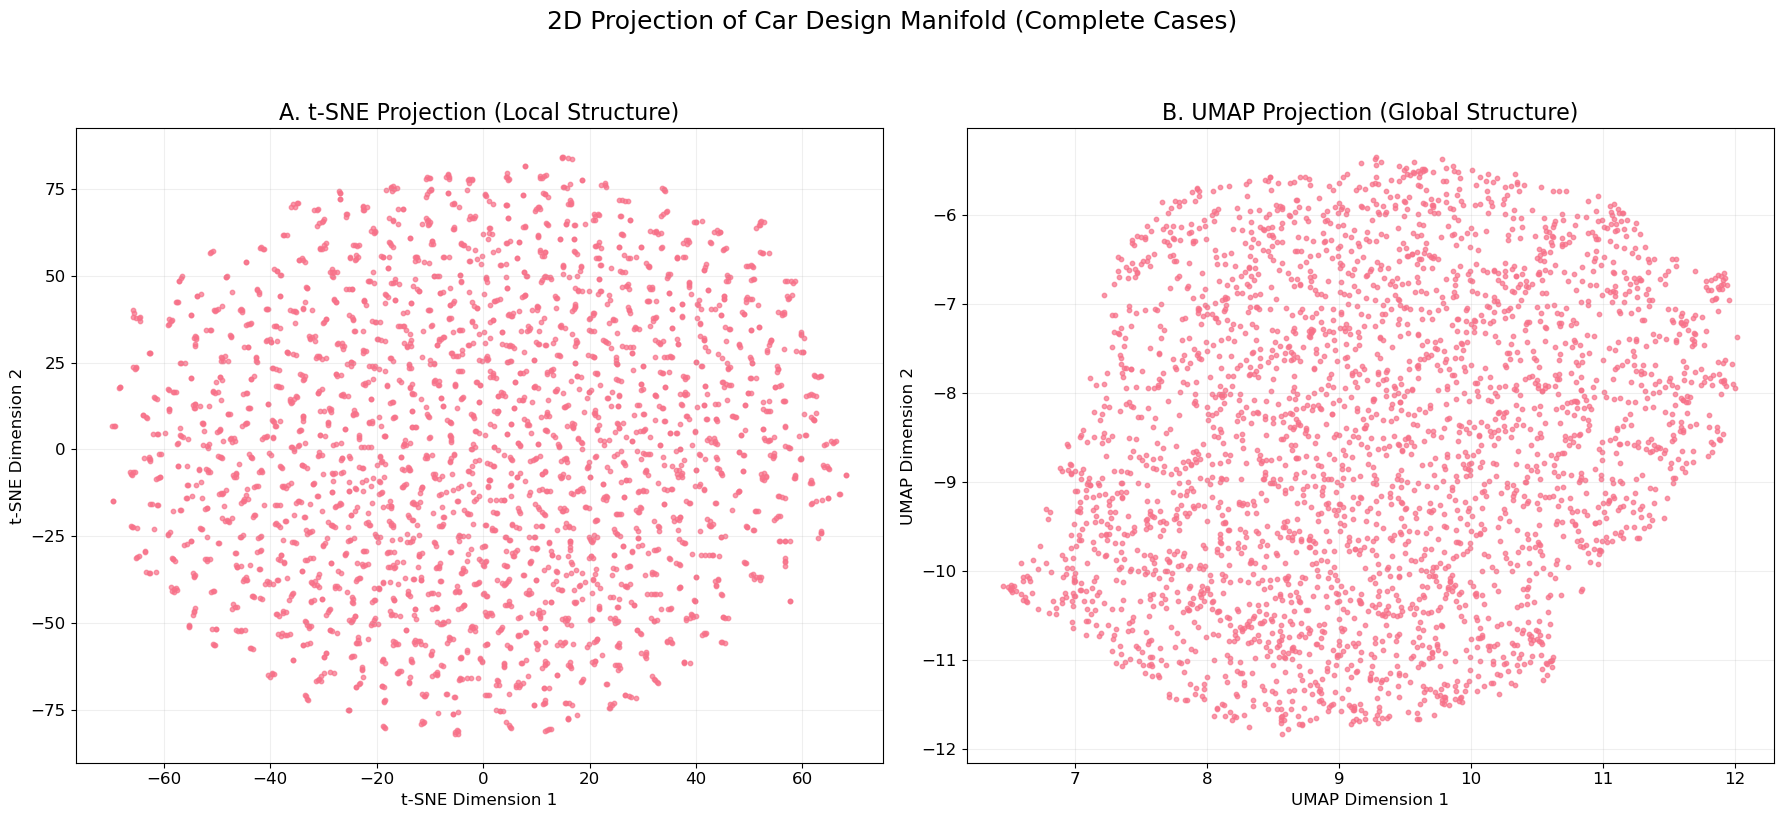

✓ N-D analysis complete. The cluster density shows the 'valid data manifold'.
  Generated car designs must ideally fall within this space.


In [10]:
# ==============================================================================
# 3. DIMENSIONALITY REDUCTION (The N-D View - Manifold Visualization)
# ==============================================================================

print("\n3. Generating Manifold Visualization using t-SNE and UMAP (N-D View)")

# 1. Clean Data: Requires complete data (no NaNs).
complete_cases = X_train_NaN.dropna()

print(f"Original samples: {X_train_NaN.shape[0]}. Complete cases used for Manifold Visualization: {complete_cases.shape[0]}")

if complete_cases.shape[0] < 50:
    print("Warning: Too few complete cases. Skipping Manifold Visualization or consider imputing for visualization.")
else:
    # 2. Scaling (Recommended for Manifold Visualization)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(complete_cases)
    
    # 3. Apply Dimensionality Reduction (Using a small, representative sample if data is very large)
    subset_size = min(5000, scaled_data.shape[0]) 
    if scaled_data.shape[0] > subset_size:
        indices = np.random.choice(scaled_data.shape[0], subset_size, replace=False)
        manifold_data = scaled_data[indices, :]
    else:
        manifold_data = scaled_data

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('2D Projection of Car Design Manifold (Complete Cases)', fontsize=18, y=1.02)

    # --- T-SNE Analysis ---
    TSNE_PERPLEXITY = 30
    RANDOM_STATE = 42
    print(f"\nRunning t-SNE (Perplexity={TSNE_PERPLEXITY}, Random State={RANDOM_STATE})...")
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY) 
    tsne_results = tsne.fit_transform(manifold_data)

    # Plotting t-SNE
    axes[0].scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, alpha=0.7)
    axes[0].set_title('A. t-SNE Projection (Local Structure)', fontsize=16)
    axes[0].set_xlabel('t-SNE Dimension 1')
    axes[0].set_ylabel('t-SNE Dimension 2')
    axes[0].grid(True, alpha=0.2)

    # --- UMAP Analysis ---
    UMAP_NEIGHBORS = 15
    UMAP_MIN_DIST = 0.1
    print(f"Running UMAP (Neighbors={UMAP_NEIGHBORS}, Min Dist={UMAP_MIN_DIST}, Random State={RANDOM_STATE})...")
    umap_reducer = UMAP(n_components=2, n_neighbors=UMAP_NEIGHBORS, min_dist=UMAP_MIN_DIST, random_state=RANDOM_STATE)
    umap_results = umap_reducer.fit_transform(manifold_data)
    
    # Plotting UMAP
    axes[1].scatter(umap_results[:, 0], umap_results[:, 1], s=10, alpha=0.7)
    axes[1].set_title('B. UMAP Projection (Global Structure)', fontsize=16)
    axes[1].set_xlabel('UMAP Dimension 1')
    axes[1].set_ylabel('UMAP Dimension 2')
    axes[1].grid(True, alpha=0.2)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    print("✓ N-D analysis complete. The cluster density shows the 'valid data manifold'.")
    print("  Generated car designs must ideally fall within this space.")


Loading dataset splits from: dataset

Loading train split...
  ✓ train_original.csv: (2998, 37)
  ✓ train_imputed.csv: (2998, 37)
  ✓ train_missing_mask.csv: (2998, 37)

Loading val split...
  ✓ val_original.csv: (375, 37)
  ✓ val_imputed.csv: (375, 37)
  ✓ val_missing_mask.csv: (375, 37)

Loading test split...
  ✓ test_original.csv: (375, 37)
  ✓ test_imputed.csv: (375, 37)
  ✓ test_missing_mask.csv: (375, 37)

Loading test2 split...
  ✓ test2_imputed.csv: (417, 37)
  ✓ test2_missing_mask.csv: (417, 37)
Using device: cpu
Data Range Check: Min=0.000, Max=1.000
Starting Diffusion Training...
Epoch 10/100 | Loss: 0.71026
Epoch 20/100 | Loss: 0.69172
Epoch 30/100 | Loss: 0.68565
Epoch 40/100 | Loss: 0.67837
Epoch 50/100 | Loss: 0.67003
Epoch 60/100 | Loss: 0.67662
Epoch 70/100 | Loss: 0.65666
Epoch 80/100 | Loss: 0.66916
Epoch 90/100 | Loss: 0.65649
Epoch 100/100 | Loss: 0.65037


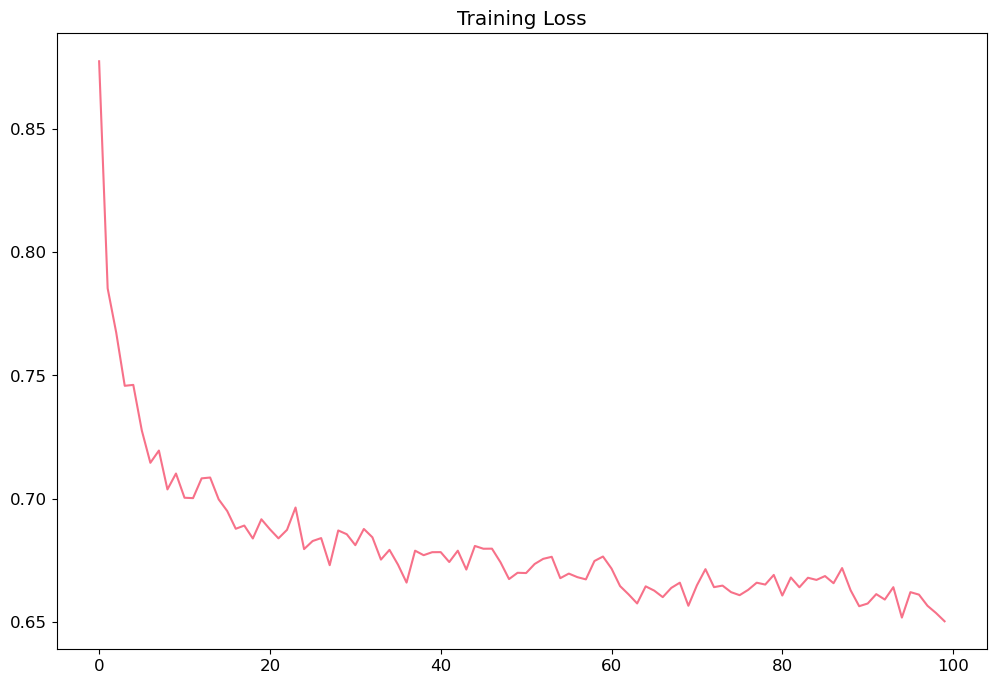


INTERNAL EVALUATION
Generating 10 samples for 375 instances...
Prediction Range: Min=0.000, Max=1.000

Average MSE on Missing Values: 0.0000


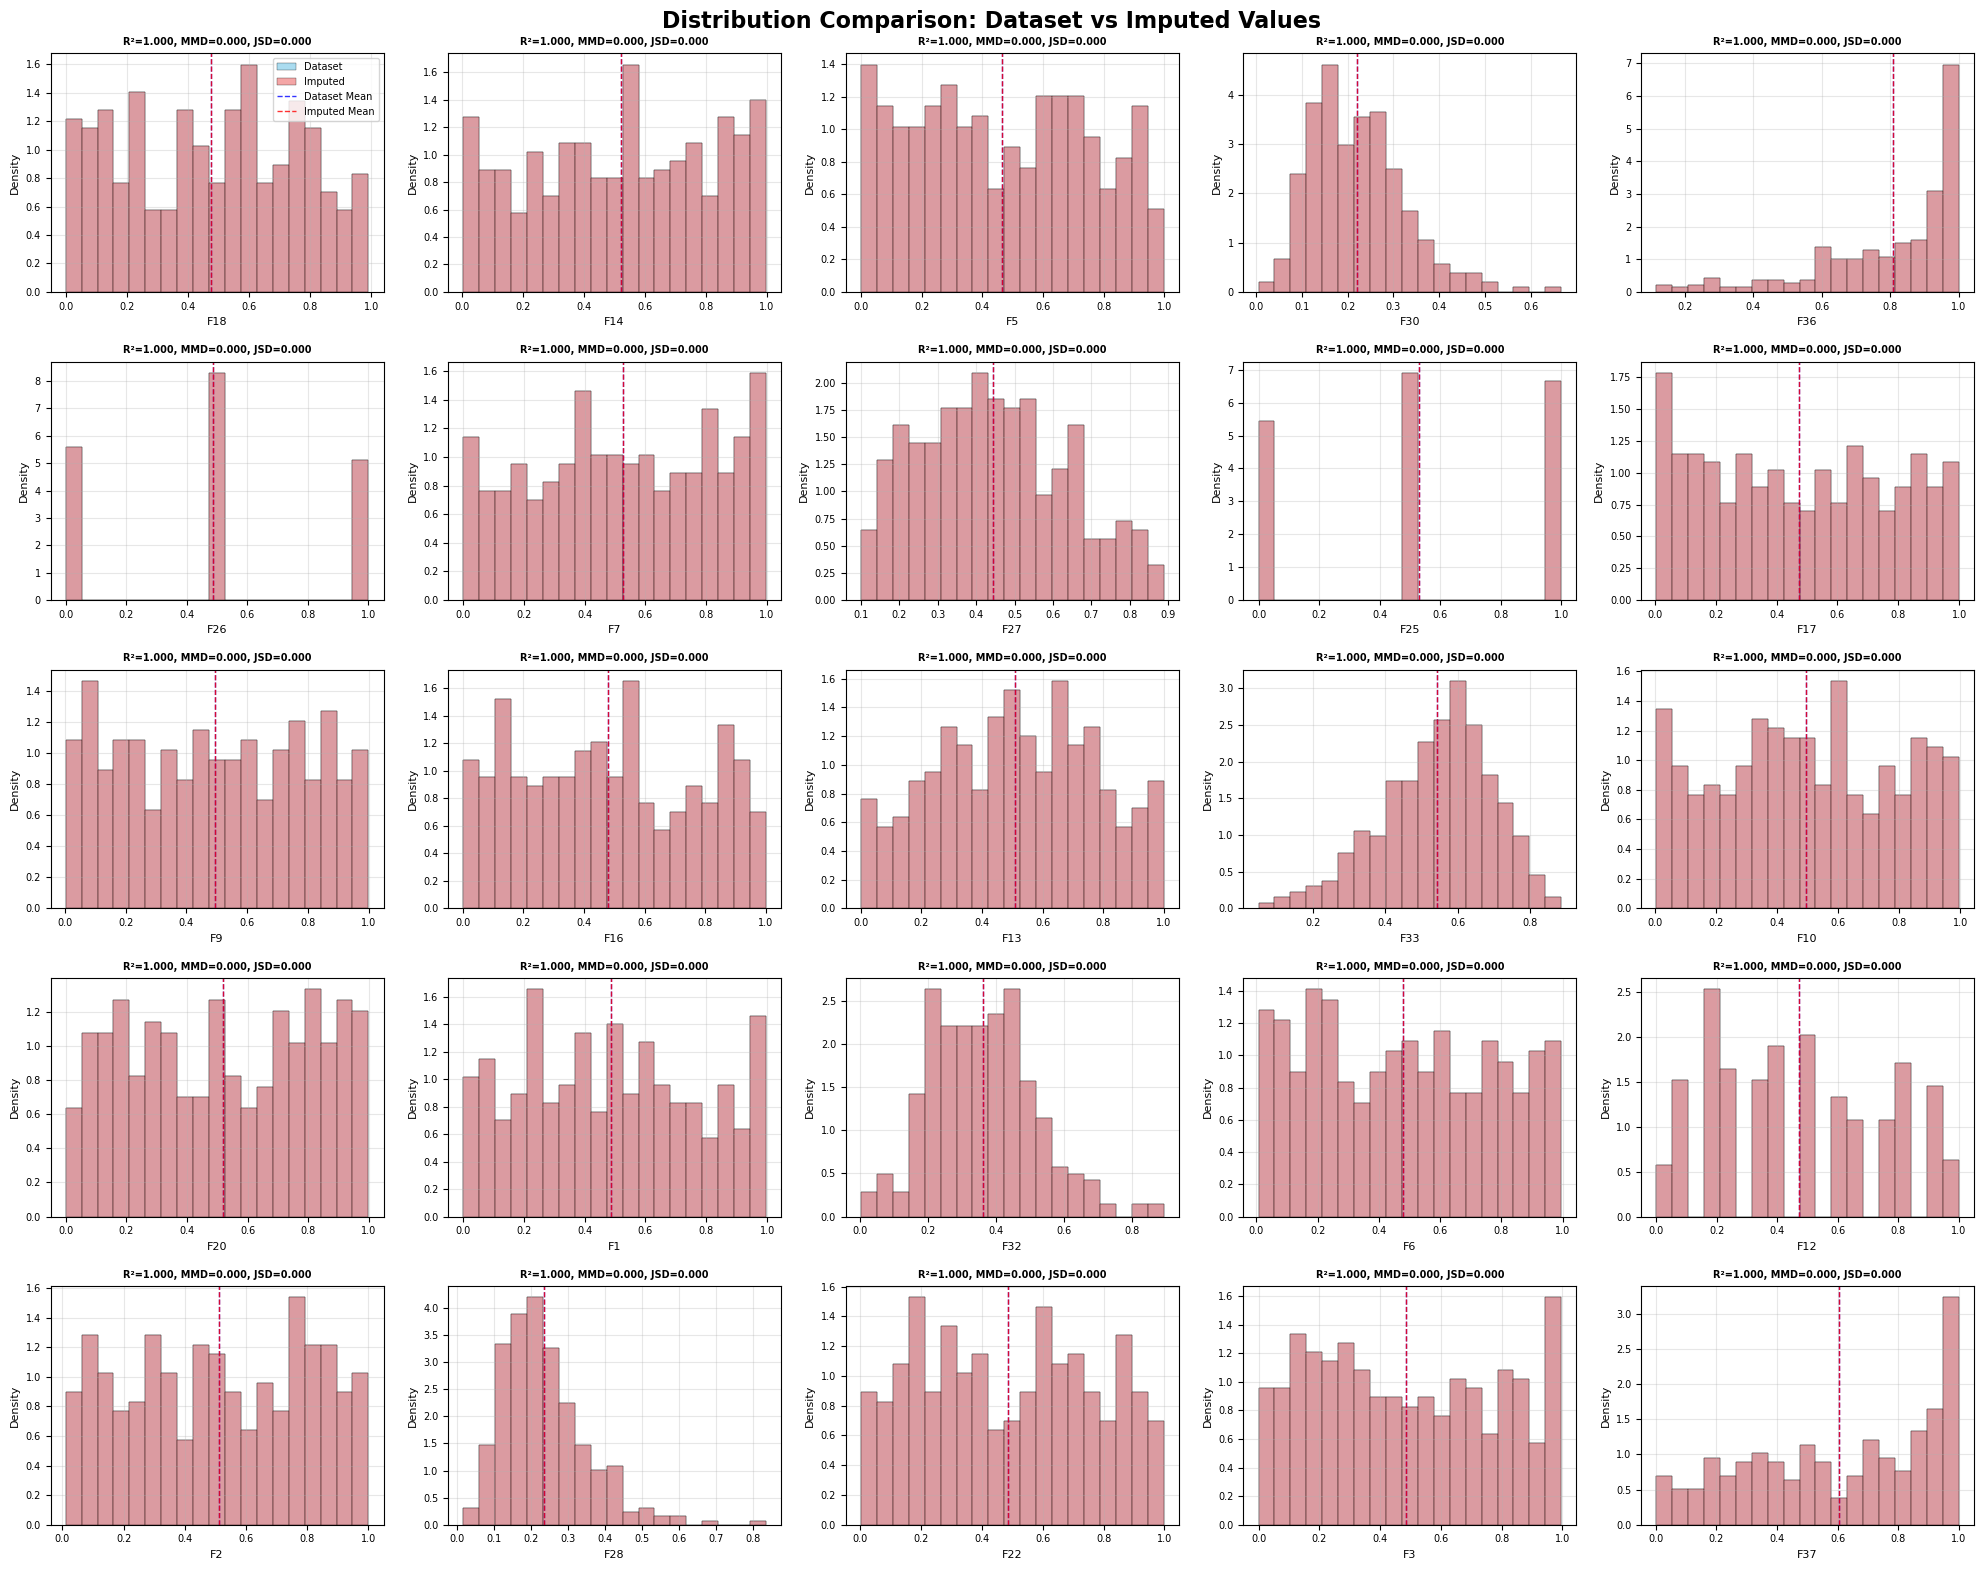

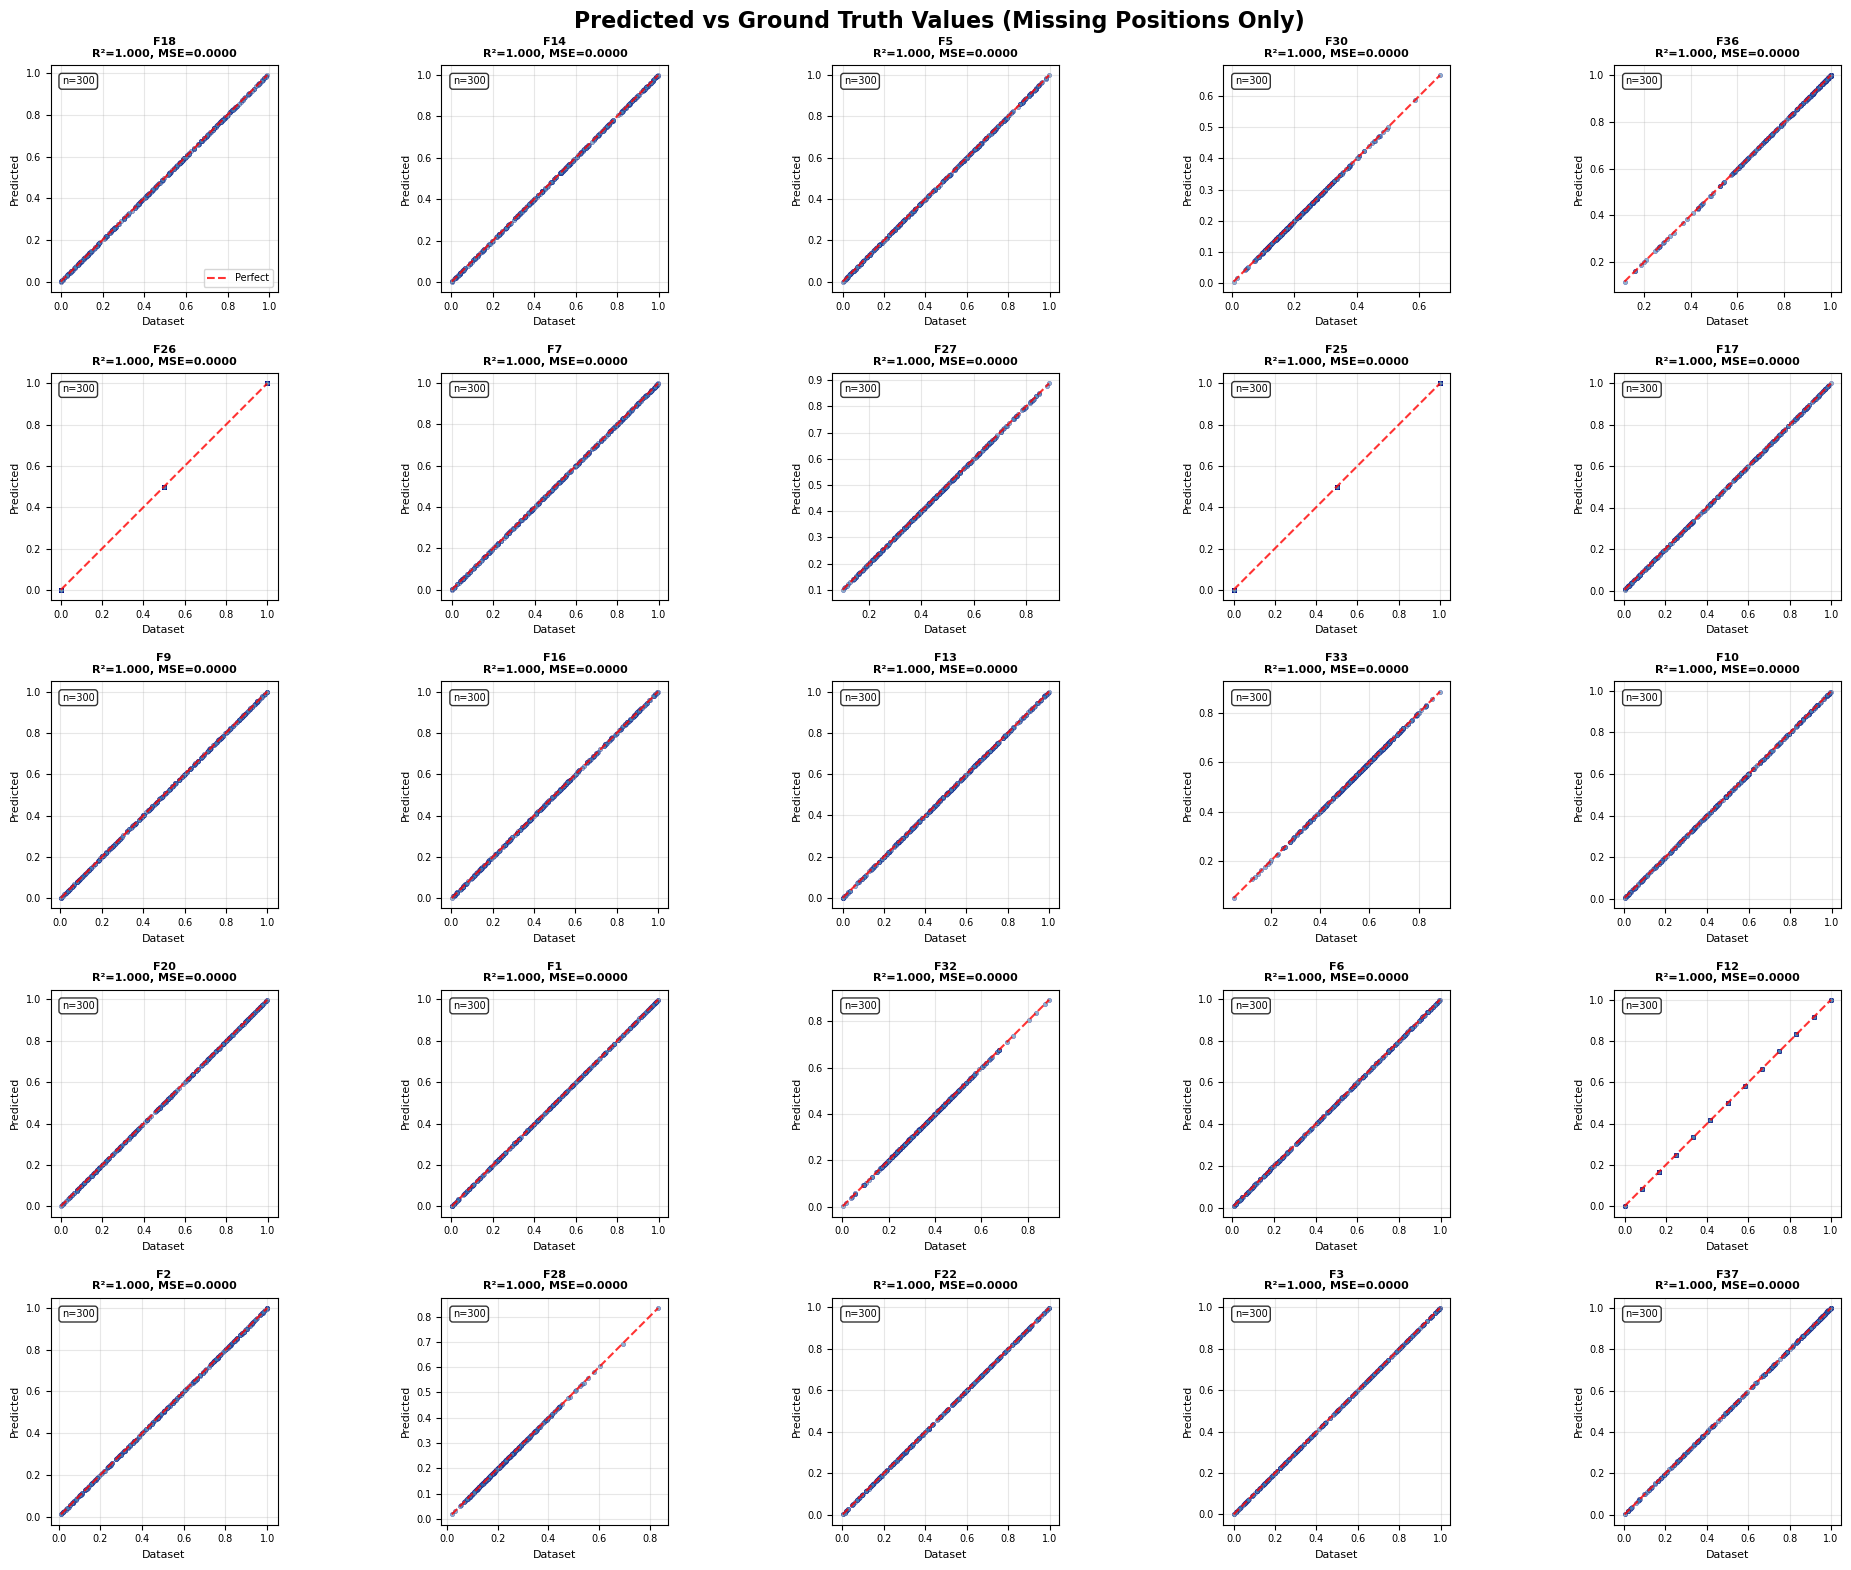


Generating Submission...
Generating 100 samples for 417 instances...
Final Submission Stats: Min=0.000, Max=1.000
Saved submission_diffusion_v4.npy


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

# Import your utils
from utils import plot_distribution_comparison, plot_prediction_scatter, load_dataset_splits

# ==========================================
# 1. STABLE MLP DIFFUSION MODEL
# ==========================================

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleDiffusion(nn.Module):
    """
    A robust, simplified MLP for Tabular Diffusion.
    Less prone to overfitting or explosion than ResNets on small data.
    """
    def __init__(self, input_dim, hidden_dims=[512, 512, 512]):
        super().__init__()
        self.input_dim = input_dim
        
        # Time embedding
        time_dim = 32
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )
        
        # Main network
        self.layers = nn.ModuleList()
        
        # First layer takes Data + Time
        in_dim = input_dim + time_dim
        
        for h_dim in hidden_dims:
            self.layers.append(nn.Sequential(
                nn.Linear(in_dim, h_dim),
                nn.BatchNorm1d(h_dim), # BatchNorm helps stabilize gradients
                nn.SiLU(),
                nn.Dropout(0.1)
            ))
            in_dim = h_dim
            
        self.final = nn.Linear(in_dim, input_dim)

    def forward(self, x, t):
        # Embed time
        t_emb = self.time_mlp(t)
        
        # Concatenate x and t
        x = torch.cat([x, t_emb], dim=1)
        
        # Pass through layers (simple MLP)
        for layer in self.layers:
            x = layer(x)
            
        return self.final(x)

# ==========================================
# 2. DIFFUSION MANAGER (With Clamping)
# ==========================================

class DiffusionManager:
    def __init__(self, model, device, timesteps=100):
        self.model = model
        self.device = device
        self.timesteps = timesteps
        
        # Linear schedule is often more stable for simple tabular tasks
        beta_start = 0.0001
        beta_end = 0.02
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

    def add_noise(self, x_0, t):
        noise = torch.randn_like(x_0)
        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t][:, None]
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t][:, None]
        return sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

    def train_step(self, batch_data, optimizer):
        self.model.train()
        optimizer.zero_grad()
        
        t = torch.randint(0, self.timesteps, (batch_data.shape[0],), device=self.device).long()
        x_t, noise = self.add_noise(batch_data, t)
        predicted_noise = self.model(x_t, t)
        
        loss = F.mse_loss(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        return loss.item()

    @torch.no_grad()
    def impute(self, x_masked, mask, n_samples_per_instance=1):
        self.model.eval()
        n_samples, n_features = x_masked.shape
        
        # Repeat for multiple samples
        x_masked = x_masked.repeat_interleave(n_samples_per_instance, dim=0)
        mask = mask.repeat_interleave(n_samples_per_instance, dim=0)
        
        # Start from random noise
        x = torch.randn_like(x_masked)
        
        for i in reversed(range(self.timesteps)):
            t = torch.full((x.shape[0],), i, device=self.device, dtype=torch.long)
            predicted_noise = self.model(x, t)
            
            beta_t = self.betas[i]
            alpha_t = self.alphas[i]
            alpha_bar_t = self.alphas_cumprod[i]
            
            # Standard DDPM Sampling
            # mean = 1/sqrt(alpha) * (x - (beta / sqrt(1-alpha_bar)) * eps)
            mean = (1 / torch.sqrt(alpha_t)) * (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * predicted_noise)
            
            if i > 0:
                noise = torch.randn_like(x)
                sigma_t = torch.sqrt(beta_t)
                x = mean + sigma_t * noise
            else:
                x = mean

            # --- INPAINTING (RePaint Strategy) ---
            if i > 0:
                # Sample known parts from the noisy ground truth distribution
                noise = torch.randn_like(x_masked)
                sqrt_alpha_prev = self.sqrt_alphas_cumprod[i-1]
                sqrt_one_prev = self.sqrt_one_minus_alphas_cumprod[i-1]
                
                # Create "correct" noisy version of known data
                known_noisy = sqrt_alpha_prev * x_masked + sqrt_one_prev * noise
                
                # Combine: Generated(Unknown) + NoisyGT(Known)
                x = x * (1 - mask) + known_noisy * mask
            else:
                # Final step: Hard enforce
                x = x * (1 - mask) + x_masked * mask
                
        return x.reshape(n_samples, n_samples_per_instance, n_features)

# ==========================================
# 3. EXECUTION
# ==========================================

splits = load_dataset_splits('dataset')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. ROBUST PREPROCESSING ---
# We capture the Min and Max of the real data to clamp predictions later
train_original = splits['train']['original']
GLOBAL_MIN = train_original.min(axis=0)
GLOBAL_MAX = train_original.max(axis=0)

print(f"Data Range Check: Min={GLOBAL_MIN.min():.3f}, Max={GLOBAL_MAX.max():.3f}")

# Use StandardScaler for training stability (Zero Mean, Unit Var)
scaler = StandardScaler()
train_data_norm = scaler.fit_transform(train_original)

train_loader = DataLoader(torch.FloatTensor(train_data_norm), batch_size=64, shuffle=True)

# --- 2. MODEL & TRAINING ---
input_dim = train_original.shape[1]
model = SimpleDiffusion(input_dim, hidden_dims=[512, 512, 512]).to(device)
manager = DiffusionManager(model, device, timesteps=100)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

print("Starting Diffusion Training...")
epochs = 100
train_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        loss = manager.train_step(batch, optimizer)
        epoch_loss += loss
        
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.5f}")
        scheduler.step(avg_loss)

plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

# --- 3. GENERATION WITH SAFETY CLAMP ---
def generate_samples_diffusion(x_imputed, n_samples_per_test=100):
    mask = (x_imputed != -1).astype(float)
    
    # Fill missing with column mean for scaling (neutral value)
    x_clean = x_imputed.copy()
    for i in range(x_clean.shape[1]):
        col = x_clean[:, i]
        valid = col[col != -1]
        if len(valid) > 0:
            mean_val = valid.mean()
            x_clean[col == -1, i] = mean_val
        else:
             x_clean[col == -1, i] = 0
             
    x_norm = scaler.transform(x_clean)
    
    x_tensor = torch.FloatTensor(x_norm).to(device)
    mask_tensor = torch.FloatTensor(mask).to(device)
    
    print(f"Generating {n_samples_per_test} samples for {x_imputed.shape[0]} instances...")
    
    batch_size = 50 
    all_outputs = []
    
    for i in range(0, len(x_tensor), batch_size):
        b_x = x_tensor[i:i+batch_size]
        b_m = mask_tensor[i:i+batch_size]
        
        with torch.no_grad():
            generated = manager.impute(b_x, b_m, n_samples_per_instance=n_samples_per_test)
            
        gen_np = generated.cpu().numpy()
        denorm_batch = np.zeros_like(gen_np)
        
        # Denormalize
        for s in range(n_samples_per_test):
            sample_s = scaler.inverse_transform(gen_np[:, s, :])
            
            # --- CRITICAL STEP: CLAMPING ---
            # Force values to stay within the valid range of the training data
            # This prevents explosion and "invisible plots"
            sample_s = np.clip(sample_s, GLOBAL_MIN, GLOBAL_MAX)
            
            denorm_batch[:, s, :] = sample_s
            
        all_outputs.append(denorm_batch)
        
    return np.concatenate(all_outputs, axis=0)

# --- 4. EVALUATION ---
print("\nINTERNAL EVALUATION")
test_imputed = splits['test']['imputed']
test_original = splits['test']['original']
test_mask = splits['test']['missing_mask']

# Generate (10 samples for speed)
eval_samples = generate_samples_diffusion(test_imputed, n_samples_per_test=10)
test_prediction_mean = eval_samples.mean(axis=1)

# Check Stats of Prediction
print(f"Prediction Range: Min={test_prediction_mean.min():.3f}, Max={test_prediction_mean.max():.3f}")

mse_scores = []
for i in range(input_dim):
    missing_idx = (test_mask[:, i] == 0)
    if missing_idx.sum() > 0:
        mse = mean_squared_error(test_original[missing_idx, i], test_prediction_mean[missing_idx, i])
        mse_scores.append(mse)

print(f"\nAverage MSE on Missing Values: {np.mean(mse_scores):.4f}")

plot_distribution_comparison(test_prediction_mean, test_original, test_mask, feature_names=[f'F{i+1}' for i in range(input_dim)])
plot_prediction_scatter(test_prediction_mean, test_original, test_mask, feature_names=[f'F{i+1}' for i in range(input_dim)])

# --- 5. SUBMISSION ---
print("\nGenerating Submission...")
X_test2 = splits['test2']['imputed']
test2_samples = generate_samples_diffusion(X_test2, n_samples_per_test=100)

print(f"Final Submission Stats: Min={test2_samples.min():.3f}, Max={test2_samples.max():.3f}")
np.save('submission_diffusion_v4.npy', test2_samples)
print("Saved submission_diffusion_v4.npy")